# Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy

> This IPython notebook replicates the analyses shown in Rebolledo-Jaramillo, Su,  et al (2014) *Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy*  [**PNAS October 28, 2014 vol. 111 no. 43 15474-15479**](http://www.pnas.org/content/111/43/15474.abstract)

> - 39 Mother-Child pairs were analysed. Blood and buccal samples were obtained from each. So, we analysed 156 independent samples in total.


> - After all samples are processed throught the alignment and filtering workflow, the final file contains allele counts for all samples at each of the 16,569 positions in the mitochondrial genome. That is 2,584,764 lines to process.


> - We will use a combination of Python and R scripts to replicate the results shown in the PNAS publication.

# Import necessary python modules

Module |  Description
-------|-------------
[pandas](http://pandas.pydata.org/) | Library providing high-performance, easy-to-use data structures and data analysis tools 
[numpy](http://www.numpy.org/) | Package for scientific computing with Python
[itertools](https://docs.python.org/2/library/itertools.html) | Functions creating iterators for efficient looping

In [1]:
import pandas as pd
import numpy as np
import itertools

# Get input data from the history. 
><i class="icon-pencil"> In this case, the allele counts are located in history item 1. To access it use "get(1)". </i>

><i class="icon-exclamation"> You need to adjust the history item to your own case when needed.

In [2]:
allelecounts=get(1)

><i class="icon-pencil"> Pandas can read tabular data directly into a dataframe. We will look at the first line of the data to identify a potential header line, and add the option accordingly to the pandas "read_table" method. 

In [3]:
with open(allelecounts) as ac:
    first_line = ac.readline()
    if first_line.startswith("#"):
        df = pd.read_table(allelecounts)
    else:
        df = pd.read_table(allelecounts,header=None)

# Prepare data
><i class="icon-pencil"> If a header is present, Pandas will assign the column names automatically, however we will standardize the column names to ease access later .

In [4]:
df.columns=["sample","reference","position","A","C","G","T","a","c","g","t","cvrg","nalleles","major","minor","maf"]

><i class="icon-pencil">  Let's take a look at the first two lines in the data frame

In [5]:
df.head(2)

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf
0,M477-ch,chrM,1,0,0,2846,0,0,0,1975,0,4821,1,G,.,0
1,M493-ch,chrM,1,0,0,3297,0,0,0,2011,0,5308,1,G,.,0


><i class="icon-pencil">  In our data, all but one mother-child pair conforms to the naming convention: </i>

mother|child
------|-----
family-tissue|familychild_number-tissue
M477-ch|M477C1-ch

><i class="icon-exclamation"> However, the pair M502G (grandmother) and M501 (mother) breaks the rule. So, we adjusted their ids accordingly.



In [6]:
old = ["M502G-ch","M502G-bl","M501-ch","M501-bl"]
new = ["M502-ch","M502-bl","M502C1-ch","M502C1-bl"]
df.replace(to_replace=old,value=new,inplace=True)

# Figure S7: Cheek and blood samples sequencing depth distribution

><i class="icon-pencil">At this point we can calculate the coverage distribution of each sample, as shown in Figure S7 in the PNAS paper.</i>

>To do so, we need to split the dataframe into blood and cheek dataframes, and make the object available to R (via [Rpy2](http://rpy.sourceforge.net/)).


In [7]:
blood = df[df['sample'].str.contains("-bl")]
cheek = df[df['sample'].str.contains("-ch")]

><i class="icon-pencil"> [Rmagic](http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html#module-rpy2.ipython.rmagic) is an extension of IPython designed to run R code. </i>

><i class="icon-exclamation"> Rmagic needs to be loaded before any work with R code can be done.</i>

In [8]:
%load_ext rpy2.ipython

><i class="icon-exclamation"> Rmagic usage specifics: </i>

One line R code |  Block of R code
----------------|-----------------
%R|%%R


><i class="icon-pencil"> Python objects are passed onto R (as data frames with headers) with the **-i** flag</i>

In [ ]:
# takes about 2 min

In [9]:
%R -i cheek,blood

><i class="icon-pencil"> Let's peek at the R version of the blood dataframe</i>

In [10]:
%%R
head(blood,2)

           sample reference position A C    G T a c    g t cvrg nalleles major
1176399 M478C2-bl      chrM        1 0 0 1425 0 0 0 1163 0 2588        1     G
1176400 M240C1-bl      chrM        1 0 0 1559 0 0 0 1379 0 2938        1     G
        minor maf
1176399     .   0
1176400     .   0


><i class="icon-pencil"> Transform numeric looking columns into actual numeric columns to guarantee the value types</i>

In [11]:
%%R
tonumeric = c(3:13,16)
blood[,tonumeric] = apply(blood[,tonumeric], 2, function(x) as.numeric(as.character(x)))
cheek[,tonumeric] = apply(cheek[,tonumeric], 2, function(x) as.numeric(as.character(x)))

><i class="icon-pencil"> Define custom R function to generate figure S7</i>

In [12]:
%%R
boxPlotCvrg = function(data,tissue){
    
    names = sort(unique(data[["sample"]]))
    data[["sample"]] = factor(data[["sample"]],levels=names)
    
    boxplot(log10(cvrg)~sample,data=data,whisklty="solid",outline=F,
            whisklwd=0.5,boxlwd=1,medlwd=1,medcol="red",main="",
            ylab="log10(coverage)",bty="n",frame=F,boxcol="white",
            boxfill="black",medlwd=3,whiskcol="grey",staplecol="grey",ylim=c(2,6))
    
    mtext(tissue,adj=0,side=3,las=1,at=length(names)/2,font=2,cex=1.25)
    }

### Plot
><i class="icon-pencil"> You can adjust the size of the plotting image by adjusting:</i>

width|height|units|resolution
-----|------|-----|----------
-w|-h|-u|-r

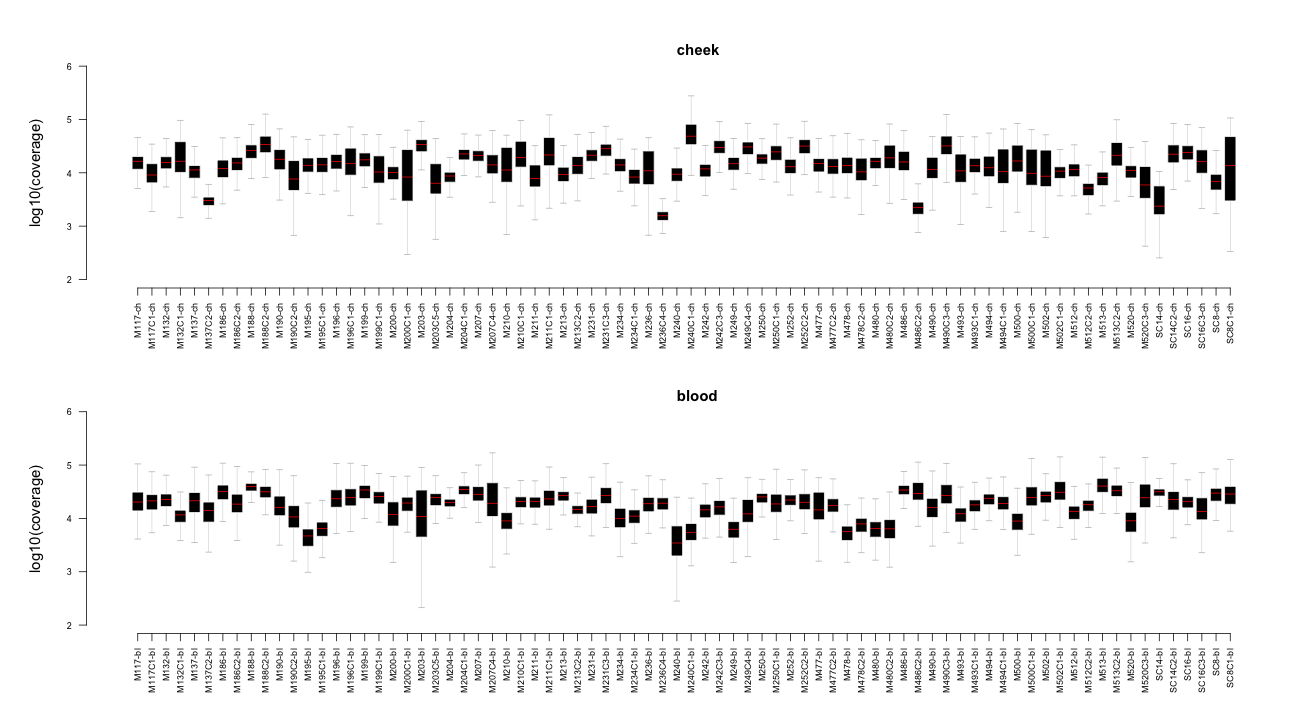

In [13]:
%%R -w 18 -h 10 -u in -r 72

par(las=2)
par(mar=c(4,4,4,1))
par(oma=c(2,2,0,0))
par(mfrow=c(2,1))
par(cex.lab=1.25)
par(cex.axis=0.75)

boxPlotCvrg(cheek,"cheek")
boxPlotCvrg(blood,"blood")

# Identification of high quality heteroplasmic sites

 ><i class="icon-pencil"> We defined high quality (HQ):</i>
 
 >1. minor allele frequency (maf) ≥ 1%
 >2. coverage ≥ 1000
 >3. maf balance (1% in forward and reverse strands)
 >4. no strand bias
 >5. outside "problematic sites":
     - mtDNA homopolymeres
     - around the artificial "N" at position 3107
     - within 50 bp of the long range PCR primers


><i class="icon-pencil"> Back in Python, we define the "problematic sites" ranges...</i>

In [14]:
mask = [(66,71),(303,311),(514,523),(12418,12425),(16184,16193),
      (3105,3109),(2817,2868),(3320,3370),(10796,10846),(11520,11570)]

maskRegions = list()
for start,end in mask:
    maskRegions+=range(start,end+1)

><i class="icon-pencil"> ... and filter the main dataframe **partially** on maf, coverage and position</i>

In [15]:
hq_sites = df[(df.maf>=0.01) & (df.cvrg>=1000) & ~df.position.isin(maskRegions)]

In [16]:
len(hq_sites)

572

><i class="icon-pencil"> By applying these initial filters, we reduced the dataframe from ~2 million lines to 572 lines only, which is much more manageable.</i>


> <i class="icon-pencil"> Next, we calculate strand bias and maf balance on these 572 sites... </i>


In [17]:
def strand_stats(x, mafThreshold=0.01):
    falleles = ['A','C','G','T']
    ralleles = ['a','c','g','t']
    sample,position,major,minor,coverage,maf = x[['sample','position','major','minor','coverage','maf']]
    fcounts = x[falleles]
    rcounts = x[ralleles]
    if minor!='.':
        index_major = falleles.index(major)
        index_minor = falleles.index(minor)

        fcount_minor = float(fcounts[index_minor])
        ftotal = fcount_minor + fcounts[index_major]
        
        rcount_minor = float(rcounts[index_minor])
        rtotal = rcount_minor + rcounts[index_major]
        
        minor_total = float(fcount_minor + rcount_minor)
        site_total = ftotal + rtotal

        try:
            strandBias = abs( (fcount_minor/ftotal) - (rcount_minor/rtotal) ) / (minor_total/site_total)
        except:
            strandBias = np.nan
            
        try:
            maf_frwd = fcount_minor/sum(fcounts)
        except:
            maf_frwd = np.nan
        try:
            maf_rvrs = rcount_minor/sum(rcounts)
        except:
            maf_rvrs = np.nan
            
        if (maf_frwd>=mafThreshold) and (maf_rvrs>=mafThreshold):
            mafBalance = 1
        else:
            mafBalance = 0
    else:
        strandBias = float(2)
        mafBalance = 0

    return pd.Series([strandBias,mafBalance])

In [18]:
biasCols = hq_sites.apply(strand_stats,axis=1,args=(0.01,))
biasCols.columns = ["strandBias","mafBalance"]
hq_sites = pd.concat([hq_sites,biasCols],axis=1)



> <i class="icon-pencil">... and filter them on maf balance and strand bias 

In [19]:
hq_sites = hq_sites[(hq_sites.strandBias<=1) & (hq_sites.mafBalance==1) ]
len(hq_sites)

184

> <i class=icon-exclamation> There is an additional screenning step not shown here, where we calculate the cycle bias of the site, i.e. whether the alternative allele is supported primarily by nucleotides within 25 bp of the read ends. It requires a list of sites and the bam files originally quantified by the Naive Variant Caller tool. The script is shown below </i> 

> There are 9 such cases, and two additional cases of sites we could not replicate with a new long range PCR (deemed PCR errors). These 11 sites are provided as an additional file in the history 

In [ ]:
#import pysam

In [ ]:
'''
-
'''

In [ ]:
'''
WORKS WITH ANOTHER DATASET. NOT TESTED FOR THE MTDNA PROJECT
# bam files need to be named accordingly: M478C2-bl.bam

bamdirbase = "/path/to/nvc/ready/bam/files/directory"


cbias = []

for sample,position,minor in hq_sites[["sample","position","minor"]].itertuples(index=False):
    sampleName = sample.split(".")[0]
    bam = "%s/srt.%s.nvcReady.bam" % (bamdirbase,sampleName)
    
    cbias.append(cycle_bias(sampleName,int(position),minor,bam))

hq_sites["cycle_bias"] = cbias
hq_sites = hq_sites[hq_sites.cycle_bias<=0.85]
len(hq_sites)
'''

In [20]:
# Read in bad sites dataset from history
knownBadhqSites = pd.read_table(get(2),header=None)

# Set bad sites column names 
knownBadhqSites.columns=["sample","position"]

# Adjust naming convention for the anomalous grandmother-mother pair
knownBadhqSites.replace(to_replace=old,value=new,inplace=True)

# Transform bad sites into a hashable object 
bad = set(knownBadhqSites.itertuples(index=False))

# Get a boolean array to filter high quality sites
good = [x not in bad for x in hq_sites[['sample','position']].itertuples(index=False)]

# Finally, filter high quality sites
hq_sites = hq_sites[good]

In [21]:
len(hq_sites)
#hq_sites.to_csv("hq173.txt",sep="\t",index=False)

173

## Statistical significance of high quality sites
> Finally, we calculate the significance of the minor allele frequency of a site provided the error rate at that position. The error rate is estimated from the remaining 155 samples, and the expected allele acounts are compared to the observed allele counts.

In [22]:
from scipy.stats import poisson

In [23]:
# We define a poisson function that will take a single high quality site, and explore the variability of
# the position among the remaining samples


def poisson_pval(current_df,sample):
    alleles = ['A','C','G','T','a','c','g','t']
    
    sample_counts = list(current_df.loc[current_df['sample']==sample, alleles].iloc[0,:])
    others_counts = list(current_df.loc[current_df['sample']!=sample, alleles].apply(sum,axis=0))
    sample_coverage = sum(sample_counts)
    
    observed_error = (sum(others_counts) - max(others_counts))/float(sum(others_counts))
    sample_nonMajor_counts = int(sample_coverage - max(sample_counts))
    
    pvalue = poisson.pmf(sample_nonMajor_counts, observed_error*sample_coverage)
    
    return pvalue

In [24]:
poisson_pvalues = []

for sample,position in hq_sites[["sample","position"]].itertuples(index=False):
    poisson_pvalues.append(poisson_pval(df[df['position']==position],sample))

    
hq_sites["poisson"] = poisson_pvalues
hq_sites = hq_sites[hq_sites.poisson<=0.05]
len(hq_sites)

173

> As described in the paper, all sites were statiscally significant under the Poisson and Likelihood (not shown here) frameworks.

# Screening for contamination
> In our previous publication, Dickins, Rebolledo-Jaramillo, et al (2014) Controlling for contamination in resequencing studies with a reproducible web-based phylogentic approach [BioTechniques, 56(3):134–141](http://goo.gl/jv2J34), we described signs of potential contamination:
 1. Many heteroplasmic sites (≥5 per sample)
 2. Tigh minor allele frequency distribution
 3. Non-family related positions
 
> <i class="icon-pencil"> We routinely apply our contamination detection pipeline, so we are confident our sites in the PNAS paper were not artifacts. As an example of the screening for contamination, we can plot the number of sites and the minor allele frequency distribution of all samples in the high quality sites set

In [25]:
# Make R aware of the hq_sites dataframe
%R -i hq_sites

In [26]:
%%R

# Adjust value types in the hq_sites dataframe

tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))
head(hq_sites,2)

      sample reference position    A C  G T    a c  g t cvrg nalleles major
2031 M490-ch      chrM      185 2663 0 73 0 3116 0 92 0 5944        2     A
2075 M490-ch      chrM      189 2519 2 29 0 3159 0 41 0 5750        0     A
     minor     maf strandBias mafBalance      poisson
2031     G 0.02776 0.07194105          1 1.010608e-05
2075     G 0.01217 0.11750754          1 1.546148e-05


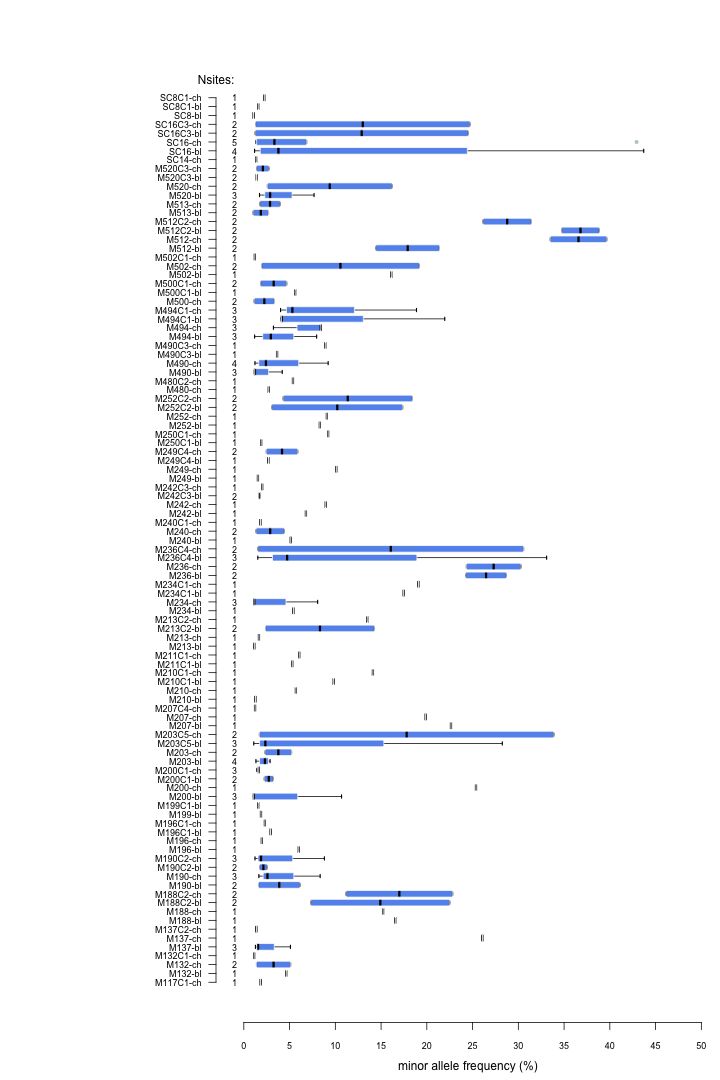

In [27]:
%%R -w 10 -h 15 -u in -r 72

# Plot hq_sites number of sites and minor allele frequency distribution
par(mar=c(4,15,4,0))
boxplot(
  maf~sample,
  data=hq_sites,
  pch=16,cex=0.75,
  outcol="azure3",outline=T,
  whisklty=1,whiskwd=1.5,
  staplelwd=1.5,
  boxwex=0.75,boxcol="white",boxfill="cornflowerblue",
  horizontal=T,cex.axis=0.75,las=2,
  frame=F,xaxt="n",ylim=c(-0.01,0.5)
  )

axis(1,at=seq(0,5,0.5)/10,lab=100*(seq(0,5,0.5)/10),cex.axis=0.75)
title(xlab="minor allele frequency (%)",line=2.5,cex.axis=0.75)

nsites = table(hq_sites[["sample"]])
for (i in 1:length(nsites)){
  text(-0.01,i,lab=nsites[i],cex=0.75)
}
mtext("Nsites:",side=3,line=-2,at=0,adj=1.25)

# Tabulating high quality sites into *quartets*

> <i class="icon-pencil"> For each high quality site, we can retrieve the minor allele frequency information for the remaining 3 samples in the family collection. So, a quartet is nothing but the tabulation of the minor allele frequency for the mother blood and cheek, and her child blood and cheek, for the same site. </i>

family|position|major|minor|mother_cheek|mother_blood|child_cheek|child_blood
------|--------|-----|-----|------------|------------|-----------|-----------
M494|9196|G|A|0.032|0.030|0.000|0.000




> <i class=icon-pencil> Before we can do that, we need to add family information to the high quality sites. </i>

> We will do that by extracting the family id from each sample's id. It is also useful to have a way to split the data by tissue or member of the pair, so we will add the columns "family", "tissue" and "member", accordingly.

In [28]:
# Get family id from sample id
# i.e. M512C1-ch returns M512

def getfamlabels(samplename):    
    nameparts = ["".join(x) for _, x in itertools.groupby(samplename, key=str.isdigit)]
    family = "".join(nameparts[:2])
    if "-ch" in nameparts:
        tissue = "cheek"
    else:
        tissue = "blood"
    
    if len(nameparts)>3:
        pairclass = "child"
    else:
        pairclass = "mother"
        
    return pd.Series([family,tissue,pairclass])

In [29]:
hq_sites[["family","tissue","member"]] = hq_sites["sample"].apply(getfamlabels)

In [30]:
hq_sites.head(2)

,sample,reference,position,A,C,G,T,a,c,g,...,nalleles,major,minor,maf,strandBias,mafBalance,poisson,family,tissue,member
2031,M490-ch,chrM,185,2663,0,73,0,3116,0,92,...,2,A,G,0.02776,0.071941,1,0.000010,M490,cheek,mother
2075,M490-ch,chrM,189,2519,2,29,0,3159,0,41,...,0,A,G,0.01217,0.117508,1,0.000015,M490,cheek,mother


####  <i class="icon-pencil"> Now we can extract the unique quartets by selecting the "family" and "position" columns

In [31]:
unique_quartets = hq_sites[["family","position"]].drop_duplicates()
len(unique_quartets)

98

In [32]:
unique_quartets.head(2)

,family,position
2031,M490,185
2075,M490,189


In [33]:
# For each family_id/position combination, 
# retrieve the information for all 4 members of the quartets
# from the original whole data dataframe

def getQuartets(hqsite):
    position = hqsite['position']
    familyid = hqsite['family']
    allmembers = [s for s in df['sample'].drop_duplicates() if s.startswith(familyid)]
    mother = min([len(x) for x in allmembers])
    child = max([len(x) for x in allmembers])
    if len(allmembers)==4:

        for member in allmembers:
            if len(member)==mother and member.endswith("-ch"):
                motherCheek = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

            elif len(member)==mother and member.endswith("-bl"):
                motherBlood = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

            elif len(member)==child and member.endswith("-ch"):
                childCheek = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

            else:
                childBlood = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

        return pd.Series([familyid,position]+list(motherCheek)+list(motherBlood)+list(childCheek)+list(childBlood))
    else:
        pass

In [34]:
quartets = unique_quartets.apply(getQuartets,axis=1)

In [35]:
quartets.columns = ["family","position","mcMajor","mcMinor","mcMAF","mbMajor","mbMinor","mbMAF",
                    "ccMajor","ccMinor","ccMAF","cbMajor","cbMinor","cbMAF"]

In [36]:
quartets.head(2)

,family,position,mcMajor,mcMinor,mcMAF,mbMajor,mbMinor,mbMAF,ccMajor,ccMinor,ccMAF,cbMajor,cbMinor,cbMAF
2031,M490,185,A,G,0.02776,A,G,0.00658,A,G,0.00393,A,G,0.00128
2075,M490,189,A,G,0.01217,A,G,0.00370,A,G,0.00208,A,G,0.00091


### <i class="icon-exclamation" > We can add even more information to the quartets table. For instance, the impact of the alternative allele and the nucleotide change class </i>

In [37]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

In [38]:
def translate(sequence,gene):
    if len(str(sequence))%3!=0:
        add=3 - (len(str(sequence))%3)
    else:
        add=0

    if genedb[gene]["strand"]==1:
        modseq=str(sequence)+add*'A'        
    else:
        modseq=str(sequence.reverse_complement())+add*'A'

    try:
        translation=str(Seq(modseq,IUPAC.unambiguous_dna).translate(table=2,cds=True))
    except:
        translation=[]

    return translation

In [39]:
def evoImpact(quartet):
    het,major,minor = quartet
    pos  = int(het)-1
    gene = [g for g in genedb if genedb[g]['end']>=pos>=genedb[g]['start']][0]

    if gene in [feature.qualifiers['gene'][0] for feature in rCRS.features if feature.type=="CDS"]:

        majorseq = rCRS.seq.tomutable()
        minorseq = rCRS.seq.tomutable()
        majorseq[pos] = major
        minorseq[pos] = minor
        ref_seq = rCRS.seq[genedb[gene]["start"]:genedb[gene]["end"]]
        major_seq = majorseq[genedb[gene]["start"]:genedb[gene]["end"]]
        minor_seq = minorseq[genedb[gene]["start"]:genedb[gene]["end"]]

        if (translate(ref_seq,gene)==translate(minor_seq,gene)):
            ptimpact = "syn"
        else:
            ptimpact = "nonsyn"
    else:
        ptimpact = "-"

    ntClass={'pu':['A','G'],'py':['C','T']}
    majorClass=[k for k,v in ntClass.iteritems() if major in v]
    minorClass=[k for k,v in ntClass.iteritems() if minor in v]
    if majorClass==minorClass:
        ntimpact='ts'
    else:
        ntimpact='tv'


    return pd.Series([ptimpact,genedb[gene]['class'],ntimpact])

In [43]:
rCRS = SeqIO.read(open(get(4),"r"), "genbank")

genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [44]:
quartets[["ptchange","class","ntchange"]] = quartets[['position','mbMajor','mcMinor']].apply(evoImpact,axis=1)

### Finalized quartets table

In [45]:
quartets.head(2)

,family,position,mcMajor,mcMinor,mcMAF,mbMajor,mbMinor,mbMAF,ccMajor,ccMinor,ccMAF,cbMajor,cbMinor,cbMAF,ptchange,class,ntchange
2031,M490,185,A,G,0.02776,A,G,0.00658,A,G,0.00393,A,G,0.00128,-,Dloop,ts
2075,M490,189,A,G,0.01217,A,G,0.00370,A,G,0.00208,A,G,0.00091,-,Dloop,ts


#  Figure S11. Number of sites per individual or family
> <i class=icon-exclamation> Since we modified the hq_sites dataframe, we have to reload it in R

In [94]:
%R -i hq_sites,quartets

In [95]:
%%R
# Adjust value types in the hq_sites dataframe

tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))
head(hq_sites,2)

      sample reference position    A C  G T    a c  g t cvrg nalleles major
2031 M490-ch      chrM      185 2663 0 73 0 3116 0 92 0 5944        2     A
2075 M490-ch      chrM      189 2519 2 29 0 3159 0 41 0 5750        0     A
     minor     maf strandBias mafBalance      poisson family tissue member
2031     G 0.02776 0.07194105          1 1.010608e-05   M490  cheek mother
2075     G 0.01217 0.11750754          1 1.546148e-05   M490  cheek mother


In [96]:
%%R

getFreq = function(data,tissue,member) {
    
    siteFreq = data.frame(table(table(as.character(data[(data[["tissue"]]==tissue) & (data[["member"]]==member),1]))))
    siteFreq = unlist(apply(siteFreq,1,FUN=function(x) rep(x[1],x[2])))
    siteFreq = as.numeric(c(rep(0,39-length(siteFreq)),siteFreq))
        
    return(siteFreq)
        }

In [97]:
%%R

symbolPlot = function(data,pos) {
    
    symbols(rep(pos,length(unique(data))),
            sort(unique(data)),circles=(data.frame(table(data))$Freq)*0.01,
            add=T,inches=F,bg="black")
}

In [98]:
%%R

boxPlotNsites = function(data,pos,addOpt="False"){                    
    boxplot(data,ylim=c(-2,maxSites),frame=F,axes=F,xlim=c(1,7),at=pos,col=rgb(0,0,0,0),
            boxlwd=2,boxcol="coral3",medcol="coral3",whisklty="solid",whiskcol="coral3",
            staplecol="coral3",add=as.logical(addOpt),outline=F)

}

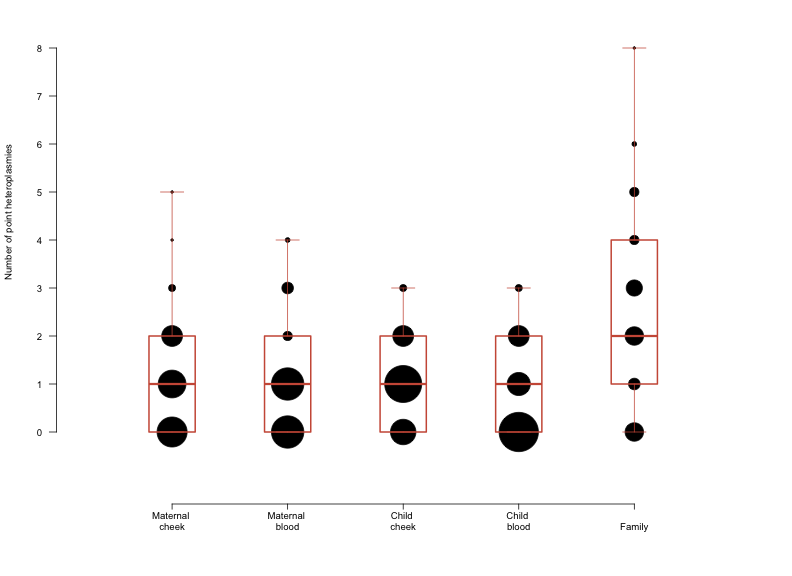

In [99]:
%%R -w 11 -h 8 -u in -r 72

mc = getFreq(hq_sites,"cheek","mother")
mb = getFreq(hq_sites,"blood","mother")
cc = getFreq(hq_sites,"cheek","child")
cb = getFreq(hq_sites,"blood","child")

fam = data.frame(table(table(quartets[["family"]])))
fam = unlist(apply(fam,1,FUN=function(x) rep(as.numeric(x[1]),x[2])))
fam = as.numeric(c(rep(0,39-length(fam)),fam))
                            
maxSites = max(c(mc,mb,cc,cb,fam))
par(mar=c(2,2,2,1))
par(oma=c(0,0,0,0))                           

plot(1:7,1:7,type="n",ylim=c(-2,maxSites),frame=F,axes=F)

symbolPlot(mc,2)
symbolPlot(mb,3)
symbolPlot(cc,4)
symbolPlot(cb,5)
symbolPlot(fam,6) 

Lab = c("Maternal \ncheek","Maternal \nblood","Child \ncheek","Child \nblood","Family")
    
axis(1,at=2:6,lab=Lab,pos=-1.5,las=1,cex.axis=0.8,tck=-0.01)
axis(2,at=0:maxSites,lab=0:maxSites,pos=1,las=2,cex.axis=0.8)
mtext("Number of point heteroplasmies",2,1,cex=0.8,adj=0.7)

      
par(new=T)
boxPlotNsites(mc,2)
boxPlotNsites(mb,3,"True")
boxPlotNsites(cc,4,"True")
boxPlotNsites(cb,5,"True")
boxPlotNsites(fam,6,"True") 

# Figure S10. Distribution of high quality heteroplasmies (STOP HERE)
inatallation of R packages is tricky

In [207]:
%%R

data = quartets
uniqueFamilies = sort(unique(as.character(data$family)))
faid = cbind(1:length(uniqueFamilies),uniqueFamilies)

plotid=c()
for (s in as.character(data$family)){
    plotid=c(plotid,faid[faid[,2]==s,1])
}
data$id = as.numeric(plotid)
data$position = as.numeric(as.character(data$position))
head(data)

      family position mcMajor mcMinor   mcMAF mbMajor mbMinor   mbMAF ccMajor
2031    M490      185       A       G 0.02776       A       G 0.00658       A
2075    M490      189       A       G 0.01217       A       G 0.00370       A
2197    M520      200       G       A 0.02581       G       A 0.01716       G
13312   M480     1211       G       A 0.02724       G       A 0.01064       G
15294   M513     1391       T       C 0.03968       T       C 0.02697       T
28384   M513     2581       A       G 0.01762       A       G 0.00043       A
      ccMinor   ccMAF cbMajor cbMinor   cbMAF ptchange class ntchange id
2031        G 0.00393       A       G 0.00128        - Dloop       ts 22
2075        G 0.00208       A       G 0.00091        - Dloop       ts 22
2197        A 0.00497       G       A 0.00156        - Dloop       ts 28
13312       A 0.00021       G       . 0.00000        -  rRNA       ts 21
15294       C 0.00111       T       C 0.00047        -  rRNA       ts 27
28384       G 0.

In [208]:
%%R
alp  =200
trna ="blue"
rrna ="lightseagreen"
prot ="orange"
dloop="red"

colors=c()
for (c in data[["class"]]) if (c=="Dloop") {
    colors=c(colors,dloop)
    } else if (c=="tRNA") {
        colors=c(colors,trna)
    } else if (c=="rRNA") {
        colors=c(colors,rrna)
    } else {
    colors=c(colors,prot)
}
data$colors=colors

In [209]:
%%R
symbol=c()
for (i in 1:nrow(data)){
    if (data[["ntchange"]][i]=="tv" & data[["ptchange"]][i]=="nonsyn") {symbol=c(symbol,17)
    } else if (data[["ntchange"]][i]=="tv" & data[["ptchange"]][i]!="nonsyn") {symbol=c(symbol,2)
    } else if (data[["ptchange"]][i]=="syn") {
          symbol=c(symbol,16)
    } else {
          symbol=c(symbol,1)}
    }
data$symbol=symbol

In [203]:
%%R
#library(shape,lib.loc="rpacks")
require(shape)

/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: shape

  res = super(Function, self).__call__(*new_args, **new_kwargs)


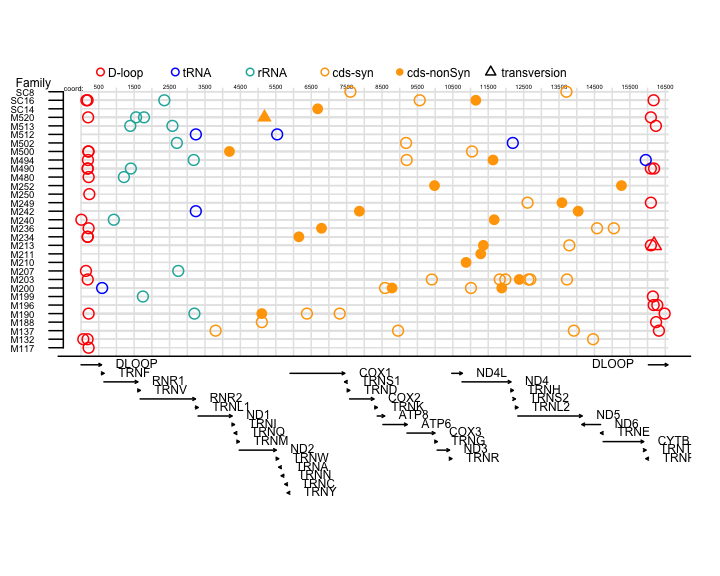

In [210]:
%%R -w 5 -h 4 -u in -r 144

# Plot area
par(mar=c(2,2,2,1))
par(oma=c(0,0,0,0))
par(las=2)
plot(data$position,data$id*5+5,xlim=c(1,16569), ylim=c(-80,170),frame="False",ylab="",axes=F, xlab="",type="n")

# Grid
for (i in data$id) {segments(1,i*5+5,16569,i*5+5,col="grey90")}
for (i in c(1,seq(500,16500,500))) {segments(i,5,i,162,col="grey90")}
for (i in seq(500,16500,1000)) {text(i,163,lab=i,col="black",cex=0.25)}
mtext("Family",3,-1.2,las=1,adj=-0.07,cex=0.5)
mtext("coord:",3,-1.35,las=1,adj=0.01,cex=0.3)

# Actual plot
points(data$position,data$id*5+5,xlim=c(1,16569), ylim=c(-80,170),pch=data$symbol,ylab="",col=data$colors, xlab="")

# Axes
abline(h=5)
lab=unique(data[,c(1,18)])
axis(2,pos=-500,at=sort(unique(data$id*5+5)),labels=lab[order(lab$id),][,1],cex.axis=0.4)

# Legend
legend(1,180,legend=c("D-loop","tRNA","rRNA","cds-syn","cds-nonSyn","transversion"),
       fill=c(NA,NA,NA,NA,NA,NA),border=c(rep("white",4),NA,NA),pch=c(1,1,1,1,16,2),
       col=c(dloop,trna,rrna,prot,prot,"black"),cex=0.5,bty="n",pt.cex=0.7,horiz=T,
       x.intersp=c(0.7,0.7,0.7,0.7,0.7,1),text.width=1350)


# mtDNA genes

Arrows(1,0,576,0,arr.length=0.05,arr.type='simple')
text(576,0,labels='DLOOP',cex=0.5,pos=4)
Arrows(576,-5,647,-5,arr.length=0.05,arr.type='simple')
text(647,-5,labels='TRNF',cex=0.5,pos=4)
Arrows(647,-10,1601,-10,arr.length=0.05,arr.type='simple')
text(1601,-10,labels='RNR1',cex=0.5,pos=4)
Arrows(1601,-15,1670,-15,arr.length=0.05,arr.type='simple')
text(1670,-15,labels='TRNV',cex=0.5,pos=4)
Arrows(1670,-20,3229,-20,arr.length=0.05,arr.type='simple')
text(3229,-20,labels='RNR2',cex=0.5,pos=4)
Arrows(3229,-25,3304,-25,arr.length=0.05,arr.type='simple')
text(3304,-25,labels='TRNL1',cex=0.5,pos=4)
Arrows(3306,-30,4262,-30,arr.length=0.05,arr.type='simple')
text(4262,-30,labels='ND1',cex=0.5,pos=4)
Arrows(4262,-35,4331,-35,arr.length=0.05,arr.type='simple')
text(4331,-35,labels='TRNI',cex=0.5,pos=4)
Arrows(4328,-40,4400,-40,arr.length=0.05,code=1,arr.type='simple')
text(4400,-40,labels='TRNQ',cex=0.5,pos=4)
Arrows(4401,-45,4469,-45,arr.length=0.05,arr.type='simple')
text(4469,-45,labels='TRNM',cex=0.5,pos=4)
Arrows(4469,-50,5511,-50,arr.length=0.05,arr.type='simple')
text(5511,-50,labels='ND2',cex=0.5,pos=4)
Arrows(5511,-55,5579,-55,arr.length=0.05,arr.type='simple')
text(5579,-55,labels='TRNW',cex=0.5,pos=4)
Arrows(5586,-60,5655,-60,arr.length=0.05,code=1,arr.type='simple')
text(5655,-60,labels='TRNA',cex=0.5,pos=4)
Arrows(5656,-65,5729,-65,arr.length=0.05,code=1,arr.type='simple')
text(5729,-65,labels='TRNN',cex=0.5,pos=4)
Arrows(5760,-70,5826,-70,arr.length=0.05,code=1,arr.type='simple')
text(5826,-70,labels='TRNC',cex=0.5,pos=4)
Arrows(5825,-75,5891,-75,arr.length=0.05,code=1,arr.type='simple')
text(5891,-75,labels='TRNY',cex=0.5,pos=4)
Arrows(5903,-5,7445,-5,arr.length=0.05,arr.type='simple')
text(7445,-5,labels='COX1',cex=0.5,pos=4)
Arrows(7445,-10,7514,-10,arr.length=0.05,code=1,arr.type='simple')
text(7514,-10,labels='TRNS1',cex=0.5,pos=4)
Arrows(7517,-15,7585,-15,arr.length=0.05,arr.type='simple')
text(7585,-15,labels='TRND',cex=0.5,pos=4)
Arrows(7585,-20,8269,-20,arr.length=0.05,arr.type='simple')
text(8269,-20,labels='COX2',cex=0.5,pos=4)
Arrows(8294,-25,8364,-25,arr.length=0.05,arr.type='simple')
text(8364,-25,labels='TRNK',cex=0.5,pos=4)
Arrows(8365,-30,8572,-30,arr.length=0.05,arr.type='simple')
text(8572,-30,labels='ATP8',cex=0.5,pos=4)
Arrows(8526,-35,9207,-35,arr.length=0.05,arr.type='simple')
text(9207,-35,labels='ATP6',cex=0.5,pos=4)
Arrows(9206,-40,9990,-40,arr.length=0.05,arr.type='simple')
text(9990,-40,labels='COX3',cex=0.5,pos=4)
Arrows(9990,-45,10058,-45,arr.length=0.05,arr.type='simple')
text(10058,-45,labels='TRNG',cex=0.5,pos=4)
Arrows(10058,-50,10404,-50,arr.length=0.05,arr.type='simple')
text(10404,-50,labels='ND3',cex=0.5,pos=4)
Arrows(10404,-55,10469,-55,arr.length=0.05,arr.type='simple')
text(10469,-55,labels='TRNR',cex=0.5,pos=4)
Arrows(10469,-5,10766,-5,arr.length=0.05,arr.type='simple')
text(10766,-5,labels='ND4L',cex=0.5,pos=4)
Arrows(10759,-10,12137,-10,arr.length=0.05,arr.type='simple')
text(12137,-10,labels='ND4',cex=0.5,pos=4)
Arrows(12137,-15,12206,-15,arr.length=0.05,arr.type='simple')
text(12206,-15,labels='TRNH',cex=0.5,pos=4)
Arrows(12206,-20,12265,-20,arr.length=0.05,arr.type='simple')
text(12265,-20,labels='TRNS2',cex=0.5,pos=4)
Arrows(12265,-25,12336,-25,arr.length=0.05,arr.type='simple')
text(12336,-25,labels='TRNL2',cex=0.5,pos=4)
Arrows(12336,-30,14148,-30,arr.length=0.05,arr.type='simple')
text(14148,-30,labels='ND5',cex=0.5,pos=4)
Arrows(14148,-35,14673,-35,arr.length=0.05,code=1,arr.type='simple')
text(14673,-35,labels='ND6',cex=0.5,pos=4)
Arrows(14673,-40,14742,-40,arr.length=0.05,code=1,arr.type='simple')
text(14742,-40,labels='TRNE',cex=0.5,pos=4)
Arrows(14746,-45,15887,-45,arr.length=0.05,arr.type='simple')
text(15887,-45,labels='CYTB',cex=0.5,pos=4)
Arrows(15887,-50,15953,-50,arr.length=0.05,arr.type='simple')
text(15953,-50,labels='TRNT',cex=0.5,pos=4)
Arrows(15955,-55,16023,-55,arr.length=0.05,code=1,arr.type='simple')
text(16023,-55,labels='TRNP',cex=0.5,pos=4)
Arrows(16024,0,16569,0,arr.length=0.05,arr.type='simple')
text(16024,0,labels='DLOOP',cex=0.5,pos=2)

# Figure 1: Correlations in minor allele frequencies

In [111]:
%%R
#head(quartets,3)
quartets[as.character(quartets$cbMinor)!=as.character(quartets$ccMinor),]

        family position mcMajor mcMinor   mcMAF mbMajor mbMinor   mbMAF ccMajor
13312     M480     1211       G       A 0.02724       G       A 0.01064       G
184185    M190      215       A       G 0.08341       A       G 0.00105       A
228195    M190     5105       T       C 0.02582       T       C 0.06139       T
265017    M494     9196       G       A 0.03235       G       A 0.02953       G
571928    M236    14573       A       G 0.30283       A       G 0.28679       A
578915    M137    16320       C       T 0.26072       C       T 0.05094       C
1017474   M240    11668       C       T 0.00045       C       T 0.00030       C
1027789   M132       64       C       T 0.00193       C       T 0.00008       C
1606253   M137     8953       A       G 0.00045       A       G 0.01268       A
1660868   M137    13918       T       C 0.00128       T       C 0.01556       T
2088522    SC8     7607       G       A 0.00725       G       A 0.01066       G
2217306   M207     2746       T       C 

> There are a few cases of reversal of mninor allele frequencies between two tissues of the same individual, or between a mother and her child. Consequently, it is necessary to fix the "ancestral" allele, and we arbitrarily decided to use the maternal blood as the ancestral state.

In [112]:
%%R


# mb = maternal blood
# mc = maternal cheek
# cb = child blood
# cc = child cheek

adjustMAF = function(row){
    
    mbMajor = row[["mbMajor"]]
    mbMinor = row[["mbMinor"]]
    mcMajor = row[["mcMajor"]]
    mcMinor = row[["mcMinor"]]
    ccMajor = row[["ccMajor"]]
    ccMinor = row[["ccMinor"]]
    cbMajor = row[["cbMajor"]]
    cbMinor = row[["cbMinor"]]
    
    if ((c(mbMajor,mbMinor) == c(mcMinor,mcMajor)) & (mcMinor!=".")){
        mcMAFadj = 1 - as.numeric(row[["mcMAF"]])
    }else{
        mcMAFadj = as.numeric(row[["mcMAF"]])
    }
    
    
    if ((c(mbMajor,mbMinor) == c(ccMinor,ccMajor)) & (ccMinor!=".")){
        ccMAFadj = 1 - as.numeric(row[["ccMAF"]])
    }else{
        ccMAFadj = as.numeric(row[["ccMAF"]])
    }
    
    
    if ((c(mbMajor,mbMinor) == c(cbMinor,cbMajor)) & (cbMinor!=".")){
        cbMAFadj = 1 - as.numeric(row[["cbMAF"]])
    }else{
        cbMAFadj = as.numeric(row[["cbMAF"]])
    }
    
    return(c(mcMAFadj,ccMAFadj,cbMAFadj))
} 

In [113]:
%%R

adjustedMAF = data.frame(t(apply(quartets, 1, adjustMAF)))
colnames(adjustedMAF) = c("mc","cc","cb")

head(adjustedMAF,2)

          mc      cc      cb
2031 0.02776 0.00393 0.00128
2075 0.01217 0.00208 0.00091


> Due to the adjustment of MAF based on the maternal state, comparing the child tissues independently of the mother's, require an additional adjustment. 

In [114]:
%%R

ccx=c()
for (maf in adjustedMAF$cc) {if (maf>0.5) ccx=c(ccx,(1-maf)) else ccx=c(ccx,maf)}
cbx=c()
for (maf in adjustedMAF$cb) {if (maf>0.5) cbx=c(cbx,(1-maf)) else cbx=c(cbx,maf)}


In [115]:
%%R

xyplot = function(x,y,sub,xtissue,ytissue,case){
    
    xLab = paste("het. allele frequency (",xtissue,")",sep="")
    yLab = paste("het. allele frequency (",ytissue,")",sep="")
    
    plot(x,y,pch=20,col="#00000078",axes=F,xlab=xLab,
         ylab=yLab,cex.lab=0.85,cex=2,xlim=c(0,1),ylim=c(0,1))

    abline(lm(x~y), col="darkgrey",lwd=1)
    mylabel = bquote(italic(R)^2 == .(round(summary(lm(x~y))$r.squared,2)))

    text(-0.05,0.7, pos=4,labels=mylabel,font=2,cex=1)
    text(-0.05,0.9,labels=case,cex=1,pos=4)
    mtext(sub,3,0.5,at=0,cex=1,font=1)
    axis(1,at=c(0,0.5,1))
    axis(2,at=c(0,0.5,1))
}

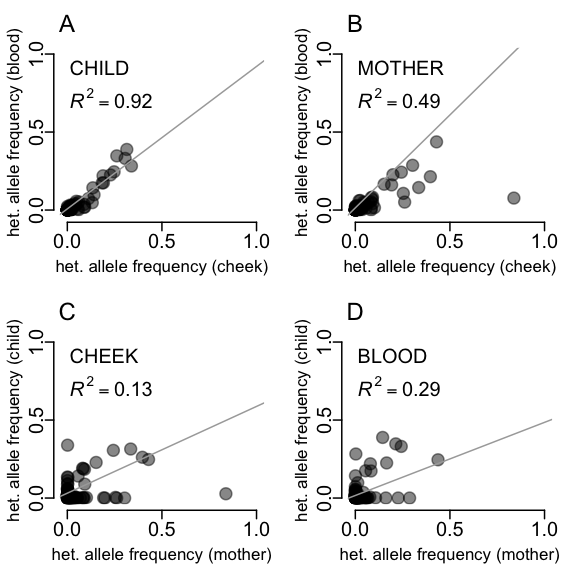

In [120]:
%%R -w 4 -h 4 -u in -r 144

par(mfrow=c(2,2))
par(oma=c(0,0,0,0))
par(mar=c(3,2.5,2,1))

par(mgp=c(1.5,0.25,0.25))
par(tck=-0.05)
    
xyplot(ccx,cbx,"A","cheek","blood","CHILD")
xyplot(adjustedMAF$mc,quartets$mbMAF,"B","cheek","blood","MOTHER")
xyplot(adjustedMAF$mc,ccx,"C","mother","child","CHEEK")
xyplot(quartets$mbMAF,cbx,"D","mother","child","BLOOD")

# Figure S15: Bottleneck size

In [183]:
%%R

bottleneckData = data.frame(
    mc=adjustedMAF$mc,
    mb=quartets[["mbMAF"]],
    cc=adjustedMAF$cc,
    cb=adjustedMAF$cb)


bottleneckData[["meanM"]] = apply(bottleneckData[,1:2], 1,mean)
bottleneckData[["meanC"]] = apply(bottleneckData[,3:4], 1,mean)

bottleneckData$bn1 = (bottleneckData$meanM*(1-bottleneckData$meanM))/(bottleneckData$meanC-bottleneckData$meanM)**2
bottleneckData$bn1.cheek =(bottleneckData$mc*(1-bottleneckData$mc))/(bottleneckData$mc-bottleneckData$cc)**2
bottleneckData$bn1.blood =(bottleneckData$mb*(1-bottleneckData$mb))/(bottleneckData$mb-bottleneckData$cb)**2



# Select cases where there is evidence of the minor allele in the maternal linage
bn1.m = bottleneckData[(bottleneckData$mc>=0.01|bottleneckData$mb>=0.01) & 
                       (bottleneckData$mc>=0.002 & bottleneckData$mb>=0.002),][["bn1"]]

bn1.cheek = bottleneckData[bottleneckData$mc>=0.01,][["bn1.cheek"]]
bn1.blood = bottleneckData[bottleneckData$mb>=0.01,][["bn1.blood"]]

In [151]:
%%R
length(bn1.m)

[1] 51


In [184]:
%%R

# Accounting for mitotic segregation

mitotic = function(row){
    mc = row[1]
    mb = row[2]
    cc = row[3]
    cb = row[4]
    variance = ((mc-cc)^2+(mc-cb)^2+(mb-cc)^2+(mb-cc)^2-2*(mc-mb)^2-2*(cc-cb)^2)/4
    return(variance)
}

bottleneckData[["mitotvar"]] = apply(bottleneckData,1,mitotic)
bottleneckData$bn2 = (bottleneckData$meanM*(1-bottleneckData$meanM))/(bottleneckData$mitotvar)
bn2.m = bottleneckData[(bottleneckData$mc>=0.01|bottleneckData$mb>=0.01) & 
                       (bottleneckData$mc>=0.002 & bottleneckData$mb>=0.002),][["bn2"]]

In [185]:
%%R
bn2.m = bn2.m[bn2.m>0]

In [154]:
%%R
length(bn2.m)

[1] 48


In [157]:
%%R
bn1.m

 [1] 1.90062772 2.27831532 1.80160610 1.71914429 1.48334902 0.03723994
 [7] 0.14342242 1.87211531 0.10769071 3.51339909 2.06432675 1.32396845
[13] 0.84669963 1.80435916 1.35202554 1.49892393 1.92432927 0.66900419
[19] 1.53338338 0.70088904 1.19681251 1.39132272 0.67132931 2.43384533
[25] 2.16729267 2.62689219 2.64003504 1.30306295 0.67506300 1.07163781
[31] 0.97231156 1.23513466 2.61380221 1.32012759 0.37898493 1.51002612
[37] 0.73525720 1.87679441 1.46301703 0.67336582 2.10684307 2.05723347
[43] 1.76534945 2.05084410 2.00249512 0.56988640 2.63559660 1.37994771
[49] 2.35812619 1.90867602 1.80354505


### Requires local installation of R packages
> vioplot (which requires package sm)

In [105]:
#!mkdir rpacks

In [106]:
%%R
#install.packages("sm",lib="rpacks")

Selection: 1


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'https://cran.rstudio.com/src/contrib/sm_2.2-5.4.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Content type 'application/x-gzip'
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning:  length 256311 bytes (250 KB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: =
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 250 KB


  res = super(Func

--- Please select a CRAN mirror for use in this session ---
HTTPS CRAN mirror 

 1: 0-Cloud [https]                    2: Austria [https]                 
 3: Chile [https]                      4: China (Beijing 4) [https]       
 5: Colombia (Cali) [https]            6: France (Lyon 2) [https]         
 7: France (Paris 2) [https]           8: Germany (M<U+00FC>nster) [https]
 9: Iceland [https]                   10: Mexico (Mexico City) [https]    
11: Russia (Moscow) [https]           12: Spain (A Coru<U+00F1>a) [https] 
13: Switzerland [https]               14: UK (Bristol) [https]            
15: UK (Cambridge) [https]            16: USA (CA 1) [https]              
17: USA (KS) [https]                  18: USA (MD) [https]                
19: USA (MI 1) [https]                20: USA (TN) [https]                
21: USA (TX) [https]                  22: USA (WA) [https]                
23: (HTTP mirrors)                    


The downloaded source packages are in
	'/tmp/Rtmpnwo7B

In [107]:
%%R
##library("sm",lib.loc="rpacks")

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Package 'sm', version 2.2-5.4: type help(sm) for summary information

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [108]:
%%R
##install.packages("vioplot",lib="rpacks")

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'https://cran.rstudio.com/src/contrib/vioplot_0.2.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning:  length 3801 bytes

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 3801 bytes


  res = super(Function, self).__call__(*new_args, **new_kwargs)



The downloaded source packages are in
	'/tmp/Rtmpnwo7B2/downloaded_packages'


In [109]:
%%R
##library("vioplot",lib.loc="rpacks")

In [124]:
%%R
require(sm,vioplot)

In [186]:
%%R

data_tmp=list(bn1.m,bn2.m)
medians=c()
first=c()
third=c()

# Get the actual values before transforming the data

for (i in 1:2){
    medians=c(medians,median(unlist(data_tmp[i])))
    first=c(first,summary(unlist(data_tmp[i]))[2])
    third=c(third,summary(unlist(data_tmp[i]))[5])
}

bn1.m = log10(bn1.m)
bn2.m = log10(bn2.m)




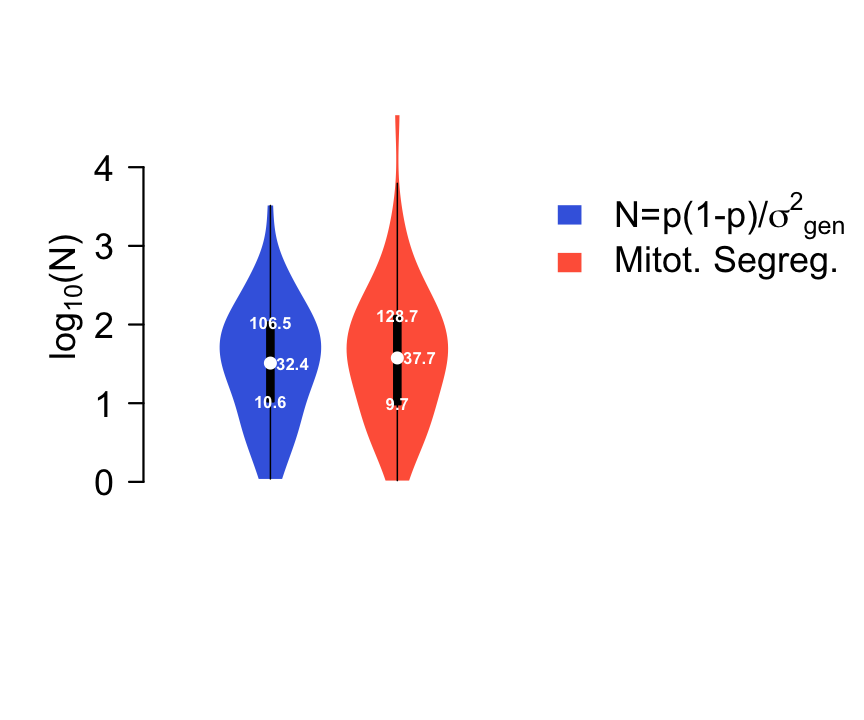

In [193]:
%%R -w 6 -h 5 -u in -r 144

par(oma=c(0,0,4,0))
par(bty="n")
par(xpd=TRUE)
par(lwd=1.5)
par(pch=20)


boxplot(bn1.m,xlim=c(0,5),ylim=c(-1,3),at=1,frame=F,axes=F, 
        ylab="",medcol="white",whiskcol="white",boxcol="white",staplecol="white")


vioplot(bn1.m,ylim=c(-1,3),at=1,col="royalblue",add=T,border=NA)
vioplot(bn2.m,ylim=c(-1,3),at=2,col="tomato",add=T,border=NA,outline=F)


axis(2,at=seq(0,4,1),lab=seq(0,4,1),pos=0,las=2,lwd=1.5,cex.axis=1.5)


#out.opt=eval(parse(text="1==1"))

labx = expression(paste("N=","p(1-p)/",sigma**2,""[gen]))
laby = expression(paste("log"[10],"(N)"))

mtext(laby,2,1,cex=1.5,adj=1)

legend(3,4,legend=c(labx,"Mitot. Segreg."),fill=c("royalblue","tomato"),bty="n",border="white",cex=1.5)

data_tmp=list(bn1.m, bn2.m)

for (i in c(1,2)) {
    y=round(median(unlist(data_tmp[i])),2)
    text(i+0.175,y,lab=round(medians[i],1),col="white",cex=0.7,font=2)
    y=round(summary(unlist(data_tmp[i]))[2],2)
    text(i,y,lab=round(first[i],1),col="white",cex=0.7,font=2)
    y=round(summary(unlist(data_tmp[i]))[5],2)
    text(i,y,lab=round(third[i],1),col="white",cex=0.7,font=2)
}


# Figure 2. Age correlations

In [233]:
%%R

countHq = function(row){
    cheek = row[1]
    blood = row[2]
    if(cheek>=0.01|blood>=0.01){
        return(1)
    }else{
        return(0)
    }
}

In [234]:
%%R

data = quartets

data$Nmother = apply(quartets[,c(5,8)],1,FUN=countHq)
data$Nchild = apply(quartets[,c(11,14)],1,FUN=countHq)
nsites = aggregate(cbind(Nmother,Nchild) ~ family, data=data,FUN=sum)

In [241]:
%%R
head(nsites)

  family Nmother Nchild
1   M117       0      1
2   M132       2      1
3   M137       3      1
4   M188       1      2
5   M190       3      3
6   M196       1      1


In [424]:
#get(38)
#mtproject_samples_age.txt

'/import/38'

In [236]:
%%R
samplesAge = read.delim("mtproject_samples_age.txt",header=F,stringsAsFactors=F)
colnames(samplesAge) = c("mother","motherAgeCollection","child","childAgeCollection")

In [240]:
%%R
head(samplesAge)

  mother motherAgeCollection  child childAgeCollection
1   M117               15933 M117C1               4047
2   M132               16658 M132C1               7460
3   M137               14294 M137C2               6202
4   M186               15938 M186C2               3504
5   M188               17714 M188C2               3451
6   M190               18761 M190C2               5866


In [250]:
%%R
ageEffect = merge(nsites,samplesAge,by.x="family",by.y="mother", all.y=TRUE)
ageEffect[is.na(ageEffect)] = 0

In [252]:
%%R
ageEffect[["motherAgeFertilization"]] = ageEffect[["motherAgeCollection"]] - (ageEffect[["childAgeCollection"]] + (9*30)) 

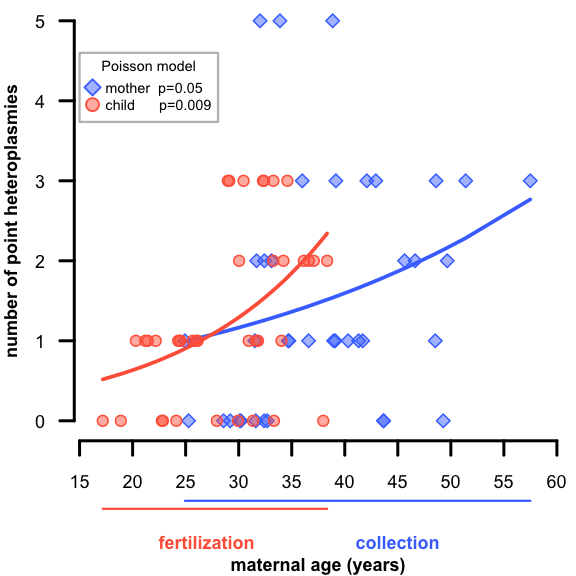

In [254]:
%%R -w 4 -h 4 -u in -r 144

black = "black"
m_col = "royalblue1"
c_col = "tomato1"

mother = rgb(matrix(col2rgb(m_col),1,3),alpha=120,maxColorValue=255)
child  = rgb(matrix(col2rgb(c_col),1,3),alpha=120,maxColorValue=255)
borders = c(m_col,c_col)


par(oma=c(0,0,0,0))
par(mar=c(0.5,2.1,0,0))


d = ageEffect[,c("Nmother","motherAgeCollection")]
plot(1:10,1:10,xlim=c(15,60),ylim=c(-1.5,5),type="n",frame=F,axes=F,xlab="",ylab="",main="")

points(d[["motherAgeCollection"]]/365,d[["Nmother"]],pch=23,col=borders[1],lwd=1,cex=1,bg=mother)
r3=glm(Nmother~motherAgeCollection,data=d,family="poisson")     
p3=round(summary(r3)$coefficients[2,4],3)
fit3=data.frame(age=r3$data$motherAgeCollection/365,f=r3$fitted.values)
fit3=fit3[order(fit3$age),]
lines(fit3$age,fit3$f,col=m_col,lwd=2.5)
x1=min(fit3$age)
x2=max(fit3$age)
pmother=round(summary(r3)$coefficients[2,4],2)


par(new=T)
c = ageEffect[,c("Nchild","motherAgeFertilization")]
points(c[["motherAgeFertilization"]]/365,c[["Nchild"]],pch=21,col=borders[2],bg=child,lwd=1,cex=1)
r3=glm(Nchild~motherAgeFertilization,data=c,family="poisson")
fit3=data.frame(con=r3$data$motherAgeFertilization/365,f=r3$fitted.values)
fit3=fit3[order(fit3$con),]
lines(fit3$con,fit3$f,col=c_col,lwd=2.5)
pchild=round(summary(r3)$coefficients[2,4],3)


axis(side=1,at=seq(15,60,by=5),lab=NA,lwd=2,pos=-0.25,cex.axis=0.75)
axis(side=2,at=0:5,lwd=2,pos=14.5,las=2,cex.axis=0.75)
mtext("number of point heteroplasmies",2,1.3,at=2.5,cex=0.75,font=2)
mtext("maternal age (years)",1,-0.5,cex=0.75,font=2)
for (i in seq(15,60,by=5)){text(i,-0.75,lab=i,cex=0.75)}

M=paste(paste("mother","p=",sep="  "),pmother,sep="")
C=paste(paste("child","p=",sep="      "),pchild,sep="")
legend(15,4.6,legend=c(M,C),col=borders,
       pt.bg=c(mother,child),pch=c(23,21),pt.cex=1.2,pt.lwd=1.2,
       cex=0.6,title="Poisson model",box.col="gray",box.lwd=1.5,bg=NA)

x3=min(fit3$con)
x4=max(fit3$con)

lines(c(x1,x2),c(-1,-1),lwd=1.5,col=m_col)
lines(c(x3,x4),c(-1.1,-1.1),lwd=1.5,col=c_col)
mtext("fertilization",1,-1.25,at=27,cex=0.75,col=c_col,font=2)
mtext("collection",1,-1.25,at=45,cex=0.75,col=m_col,font=2)



